# 1. Introducción

En el siguiente ejercicio se realizará la **rotación a 90°** de una imagen.

El algoritmo está basado en la **matriz de rotación** ampliamente difundida en plataformas en materia de álgebra como Wolfram [1]:

<center>
$$
\left(\begin{array}{cc} 
\cos\alpha & -\sin\alpha\\
\sin\alpha & \cos\alpha
\end{array}\right)
$$ 
</center>

La idea principal es mostrar la perfomance del funcionamiento de **estructuras de dos dimensiones** para gran cantidad de elementos.

Se utilizará Python [2] con las prestaciones brindadas por CUDA [3][4] para el uso de tecnología GPGPU en la plataforma Colab [5][6].

En este último aspecto, se implementó **una función kernel** que se encargan de la **interpolación** de los píxeles de la imagen original hacia la nueva imagen, formando así una imagen rotada.

---
# 2. Armado del ambiente


### Importación de módulo **CUDA** y **bibliotecas**


In [2]:
# Instalamos CUDA para Python
!pip install pycuda

# Importamos el driver y el compilador para CUDA
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

# Importamos bibliotecas estándares de Python
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image 
import numpy
from datetime import datetime

     |████████████████████████████████| 1.6MB 9.5MB/s 
     |████████████████████████████████| 71kB 11.2MB/s 
     |████████████████████████████████| 81kB 10.2MB/s 
  Created wheel for pycuda: filename=pycuda-2020.1-cp36-cp36m-linux_x86_64.whl size=621146 sha256=9dbb33c82ab94f0379ac78452746fbd8585808ef90a84a97773bafabd3a4d8e7
  Stored in directory: /root/.cache/pip/wheels/8f/78/d1/5bb826f81d9d490297a348d818ff3ee6dd6f2075b06dde6ea0
  Created wheel for pytools: filename=pytools-2020.4.3-py2.py3-none-any.whl size=61374 sha256=dedbd470322403840ef8fa0b61349995c4f1776f305353a501c6e27ecc6e5ec4
  Stored in directory: /root/.cache/pip/wheels/af/c7/81/a22edb90b0b09a880468b2253bb1df8e9f503337ee15432c64
Successfully built pycuda pytools


### Obtenemos la imagen

In [4]:
#@title ### 2.1. Parámetros de ejecución
#@markdown ---
#@markdown URL de la imagen:
url_imagen = "https://www.nasa.gov/sites/default/files/styles/full_width_feature/public/thumbnails/image/pia22207-16.jpg" #@param {type:"string"}
#@markdown ---

# Validamos la URL de la imagen
if url_imagen == "":
  raise TypeError("Se debe ingresar la URL de la imagen.")

# Obtenemos la imagen desde internet
!wget {url_imagen} -O imagen.jpg

--2020-12-02 21:05:32--  https://www.nasa.gov/sites/default/files/styles/full_width_feature/public/thumbnails/image/pia22207-16.jpg
Resolving www.nasa.gov (www.nasa.gov)... 13.224.10.123, 13.224.10.113, 13.224.10.18, ...
Connecting to www.nasa.gov (www.nasa.gov)|13.224.10.123|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 139401 (136K) [image/jpeg]
Saving to: ‘imagen.jpg’

imagen.jpg          100%[===================>] 136.13K   789KB/s    in 0.2s    

2020-12-02 21:05:33 (789 KB/s) - ‘imagen.jpg’ saved [139401/139401]



---
# 3. Desarrollo

Dim. Thread x:  16  - Dim. Bloque x: 37
Dim. Thread y:  16  - Dim. Bloque y: 66 

Tiempo Total: 919.211 [ms]
Tiempo de conversión de imagen:  2.75 [ms]


Imagen orginal: imagen.jpg - [586, 1041]



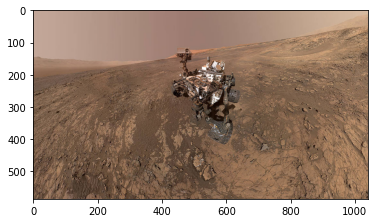

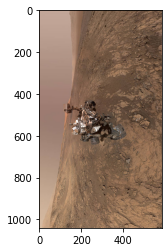

In [5]:
# Definición de función que transforma el tiempo en milisegundos 
tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0

# El ejercicio podría fallar si no se importaron los recursos necesarios o no se cargó una imagen
# Es por eso que envolvemos el código en un bloque try, de esta forma
# se le indica al usuario cómo proceder
try:
  # Capturamos el tiempo inicial
  tiempo_total = datetime.now()

  # Indicamos la imagen a cargar y creamos el objeto
  img_nombre = 'imagen.jpg'
  image = Image.open(img_nombre) 
    
  # Obtenemos las proporciones de la imagen  
  img_alto, img_ancho = image.size 

  # Pasamos la imagen original comprimida en JPEG/PNG a array
  img_O_cpu = numpy.asarray(image)

  # Creamos una nueva imagen con las dimensiones invertidas
  image_rot = Image.new(mode = "RGB", size = (img_ancho, img_alto)) 
  img_R_cpu = numpy.empty_like(image_rot)

  # GPU - Reservamos los dos vectores en GPU (3 pixeles usa RGB * tamaño del array)
  img_O_gpu = cuda.mem_alloc(img_O_cpu.nbytes)
  img_R_gpu = cuda.mem_alloc(img_R_cpu.nbytes)

  # GPU - Copiamos la memoria al GPU
  cuda.memcpy_htod(img_O_gpu, img_O_cpu)
  cuda.memcpy_htod(img_R_gpu, img_R_cpu)

  # CPU - Definimos la función kernel que ejecutará GPU
  module = SourceModule("""
  __global__ void kernel_img( int ancho, int alto, char *img_O, char *img_R){
    // Calculo las coordenadas del Thread en dos dimensiones.
    int idx = threadIdx.x + blockIdx.x*blockDim.x;
    int idy = threadIdx.y + blockIdx.y*blockDim.y;
    float rojo = 0.0, verde = 0.0, azul = 0.0;

    // Verifico que los Thread, esten dentro de las dimensiones de la imagen.
    if(idx < ancho && idy < alto){
      rojo = (float) img_O[(idy + (idx * alto)) * 3];
      verde = (float) img_O[(idy + (idx * alto)) * 3 + 1];
      azul = (float) img_O[(idy + (idx * alto)) * 3 + 2];

      img_R[(idx + (idy * ancho)) * 3] = (char) rojo;
      img_R[(idx + (idy * ancho)) * 3 + 1] = (char) verde;
      img_R[(idx + (idy * ancho)) * 3 + 2] = (char) azul;
    }
  }
  """) 

  # CPU - Obtenemos la función kernel
  kernel = module.get_function("kernel_img")

  # Capturamos el tiempo inicial de GPU
  tiempo_img = datetime.now()

  # GPU - Definimos la dimensión de threads y bloques
  dim_hilo_x = 16
  dim_bloque_x = numpy.int((img_ancho + dim_hilo_x - 1) / dim_hilo_x)
  dim_hilo_y = 16
  dim_bloque_y = numpy.int((img_alto + dim_hilo_y - 1) / dim_hilo_y)

  # GPU - Ejecuta el kernel para la rotación
  kernel( numpy.int32(img_ancho), numpy.int32(img_alto), img_O_gpu, img_R_gpu, block=( dim_hilo_x, dim_hilo_y, 1 ), grid=(dim_bloque_x, dim_bloque_y,1) )

  # GPU - Copio el resultado desde la memoria GPU a la memoria CPU
  cuda.memcpy_dtoh(img_R_cpu, img_R_gpu)

  # Captura el tiempo total del algoritmo y de todo el ejercicio
  tiempo_img = datetime.now() - tiempo_img 
  tiempo_total = datetime.now() - tiempo_total

  # Mostramos el resultado del proceso
  print("Dim. Thread x: ", dim_hilo_x, " - Dim. Bloque x:", dim_bloque_x)
  print("Dim. Thread y: ", dim_hilo_y, " - Dim. Bloque y:", dim_bloque_y, "\n")
  print("Tiempo Total:", tiempo_en_ms(tiempo_total), "[ms]")
  print("Tiempo de conversión de imagen: ", tiempo_en_ms(tiempo_img), "[ms]\n\n")
  print("Imagen orginal: " + img_nombre + " - [" + str(img_ancho) + ", " + str(img_alto) + "]\n")  
  plt.figure()
  imgplot = plt.imshow(img_O_cpu)
  plt.figure()
  imgplot = plt.imshow(img_R_cpu)
except:
  print("Ups! Algo salió mal, ¿Realizó la preparación previa del ambiente y cargó la imagen?")

---
# 4. Tabla de pasos

Procesador|Función|Detalle
---|---|---
CPU|pip install pycuda|Importa el módulo de CUDA para Python.
CPU|import|Importa los módulos para funcionar.
CPU|matplotlib inline|Macro de Colab para mostrar imagenes.
CPU|@param|Lectura de la dirección URL de la imagen (jpg) a procesar.
CPU|wget|Obtenemos la imagen del servidor indicado.
CPU|datetime.now()|Toma el tiempo inicial del ejercicio.
CPU|Image.open()|Abre el archivo de la imagen.
CPU|image.size|Obtenemos las dimensiones de la imagen.
CPU|numpy.asarray(imagen)|Convierte el formato comprimido JPG a RAW.
CPU|Image.new|Genera la imagen que será el resultado
CPU|numpy.empty_like()|Genera un array con la misma forma y tipo de dato del especificado. 
**GPU**|cuda.mem_alloc()|Reserva la memoria para las imágenes en GPU.
**GPU**|cuda.memcpy_htod()|Copiamos los arrays desde la memoria CPU a la memoria GPU.
CPU|SourceModule()|Definimos la función kernel.
CPU|module.get_function()|Obtenemos la función kernel.
CPU|datetime.now()|Toma el tiempo inicial del algoritmo.
**GPU**|dim_hilo_x, dim_hilo_y|Calcula las dimensiones.
**GPU**|kernel()|Ejecuta el kernel en GPU.
**GPU**|cuda.memcpy_dtoh|Copiamos la imagen resultado desde memoria GPU a memoria CPU.
CPU|datetime.now()|Toma los tiempos finales.
CPU|print()|Mostramos el resultado del proceso.
CPU|plt.imshow|Mostramos las imágenes (original y resultante).

---
# 5. Conclusiones

Se realizaron las siguientes pruebas:

Dimensión de la imagen [px.px]|Tiempo Rotación [ms]|Tiempo Total [ms]|Relación tiempos [%] 
---|---|---|---
700x700|0.83|18.33|4.53
1024x1034|1.79|40.69|4.40
1280x1920|2.56|67.72|3.78
3000x3000|8.62|191.25|4.51

Podemos decir que:
*   A comparación de la versión CPU, el tiempo necesario para aplicar el algoritmo en GPU respecto al tiempo total es muy ínfimo, esto claramente se debe al **paralelismo** en el tratamiento de la imagen resultante. Antes, en CPU, cada pixel se trataba de a uno por vez, por lo que había que reconstruir la imagen resultante pixel por pixel, de esta forma los tiempos crecían rápidamente a medida que la superficie de la imagen era mayor. Ahora, en GPU, los distintos pixeles que conforman la imagen pueden ser tratados por separado, de esta manera, la imagen resultante se construye en mucho menos tiempo, y esto se nota especialmente a medida que la superficie de la imagen crece.

*   Los tiempos pasaron de tener un crecimiento cuadrático a un **crecimiento lineal**. Podemos notar que la mayor parte del tiempo se lo lleva la parte del proceso que formatea la imagen original y su traspaSo al módulo de GPU, y esto aumenta a medida que la superficie de la imagen crece, lo que es razonable (aunque, como dijimos, en bastante menor tiempo que en su versión CPU).

Consideramos, entonces, que el uso de GPU en operaciones entre estructuras de dos dimensiones son excelentes para esta clase de aplicaciones, principalmente porque podemos reducir la complejidad de los problemas (cuadráticos a lineales), lo que se traduce en mucho menor tiempo de procesamiento.

Una manera de mejorar el ejercicio podría ser el hecho de poder elegir el ángulo de rotación de la imagen, en formato radial o grados sexagesimales, y mediante la matriz de rotación presentada, poder generar muchas imágenes distintas según nuestras preferencias.

---
# 6. Bibliografía

[1] Matriz de rotación, Wolfram: [Página web](https://mathworld.wolfram.com/RotationMatrix.html)

[2] Introducción a Python: [Página Colab](https://github.com/wvaliente/SOA_HPC/blob/main/Documentos/Python_Basico.ipynb)

[3] Documentación de CUDA para Python: [Página web](https://documen.tician.de/pycuda/index.html)

[4] Transposición de matrices usando CUDA: [Documentación NVIDIA](https://developer.nvidia.com/blog/efficient-matrix-transpose-cuda-cc/)

[5] Sintaxis Markdown Colab: [PDF](https://github.com/wvaliente/SOA_HPC/blob/main/Documentos/markdown-cheatsheet-online.pdf)

[6] Tutorial Point Colab: [PDF](https://github.com/wvaliente/SOA_HPC/blob/main/Documentos/markdown-cheatsheet-online.pdf)
